# Parse `.genx` Files
Parse `.genx` files from SSW into Python in order to calculate AIA wavelength response functions.

In [104]:
import sys
import os

import numpy as np
import scipy.io
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

%matplotlib inline

Next, open up the instrument file. We'll use the most recent version of the files, V6. The `_fullinst` file should contain most of the information that we need. These `.genx` files have been read into IDL and then resaved as normal IDL `.sav` files.

In [122]:
v6_all_fullinst_genx = scipy.io.readsav('/Users/willbarnes/Documents/Projects/gsoc/aia_response/ssw_aia_response_data/aia_V6_all_fullinst')

Because of the way the files were saved, all of the information is inside the `data` keyword.

In [123]:
v6_all_fullinst_genx = v6_all_fullinst_genx['data']

The data structure returned here is a [`numpy.recarray`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.recarray.html). Here is a [brief tutorial](http://docs.scipy.org/doc/numpy-1.10.1/user/basics.rec.html) on how to use these data structures. 

In [124]:
type(v6_all_fullinst_genx)

numpy.recarray

What are the members and how do we access them?

In [125]:
v6_all_fullinst_genx.dtype.names

('FILENAME',
 'DATE',
 'CODENAME',
 'CODEVERSION',
 'NAME',
 'FILEPATH',
 'MAKECHANFILES',
 'CHANNELS',
 'A94',
 'A94_FULL',
 'A94_FILE',
 'A131',
 'A131_FULL',
 'A131_FILE',
 'A171',
 'A171_FULL',
 'A171_FILE',
 'A193',
 'A193_FULL',
 'A193_FILE',
 'A211',
 'A211_FULL',
 'A211_FILE',
 'A304',
 'A304_FULL',
 'A304_FILE',
 'A335',
 'A335_FULL',
 'A335_FILE',
 'A94_THICK',
 'A94_THICK_FULL',
 'A94_THICK_FILE',
 'A131_THICK',
 'A131_THICK_FULL',
 'A131_THICK_FILE',
 'A171_THICK',
 'A171_THICK_FULL',
 'A171_THICK_FILE',
 'A193_THICK',
 'A193_THICK_FULL',
 'A193_THICK_FILE',
 'A211_THICK',
 'A211_THICK_FULL',
 'A211_THICK_FILE',
 'A304_THICK',
 'A304_THICK_FULL',
 'A304_THICK_FILE',
 'A335_THICK',
 'A335_THICK_FULL',
 'A335_THICK_FILE',
 'NOTES')

Let's look at the 94 Å data. It turns out that each member is a numpy array of length one and that the first (and only) entry is again a `numpy.recarray`. So let's see what this data structure looks like. 

__NOTE__: `A<CHANNEL_NUM>` just contains wavelength, effective area, and the platescale while `A<CHANNEL_NUM>_FULL` contains many more pieces of data, such as information about the primary and secondary mirrors and the CCD. Furthermore, `A<CHANNEL_NUM>_FILE` is just a single filename, maybe where this data lived originally though it is not clear where this file actually lives or if it is accessible at all.

In [126]:
v6_all_fullinst_genx['a94_full'][0].dtype.names

('WAVE',
 'EFFAREA',
 'UNITS',
 'FILENAME',
 'DATE',
 'NAME',
 'GEOAREA',
 'SCALE',
 'PLATESCALE',
 'NUMFILTERS',
 'NUMMIRRORS',
 'INFILEPATH',
 'OUTFILEPATH',
 'WAVEMIN',
 'WAVESTEP',
 'WAVENUMSTEPS',
 'WAVELOG',
 'USEWAVEFILE',
 'WAVEFILE',
 'FILTERSINCLUDEMESH',
 'MESHTRANS',
 'USECONTAM',
 'CONTAMFILE',
 'CONTAMTHICK',
 'USEPHOTTOELEC',
 'ELECPEREV',
 'USEPHOTTODN',
 'ELECPERDN',
 'USEERROR',
 'ERRORFILE',
 'EXTRAPOLATECOMPONENTS',
 'ENT_FILTER',
 'ENT_FILTER_FILE',
 'FP_FILTER',
 'FP_FILTER_FILE',
 'PRIMARY',
 'PRIMARY_FILE',
 'SECONDARY',
 'SECONDARY_FILE',
 'CCD',
 'CCD_FILE',
 'CONTAM',
 'CONTAM_FILE',
 'CROSS_AREA')

In [127]:
v6_all_fullinst_genx['a94'][0]['wave']

array([ array([  25.        ,   25.10000038,   25.20000076, ...,  899.79998779,
        899.90002441,  900.        ], dtype=float32)], dtype=object)

Try plotting the effective area as a function of $\lambda$ for each channel.

Plotting channel A94
Plotting channel A131
Plotting channel A171
Plotting channel A193
Plotting channel A211
Plotting channel A304
Plotting channel A335


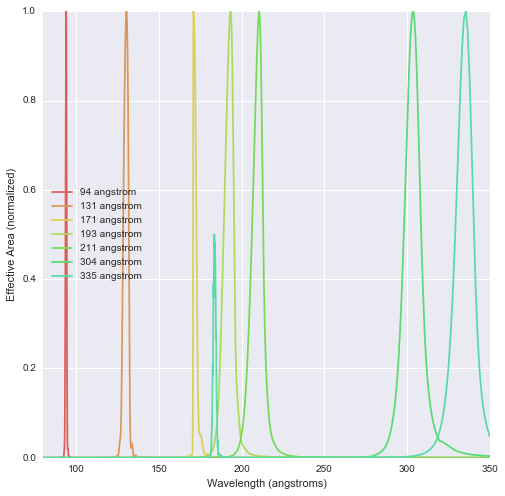

In [156]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
cp = sns.color_palette('hls',int(len(v6_all_fullinst_genx['channels'][0])))
for channel,i in zip(v6_all_fullinst_genx['channels'][0],range(len(v6_all_fullinst_genx['channels'][0]))):
    #skip the thick channels
    if b'thick' in channel or b'THICK' in channel:
        continue
    print('Plotting channel %s'%(channel.decode('utf8')))
    wavelength,a_eff = v6_all_fullinst_genx[channel.decode('utf8')][0]['wave'][0],v6_all_fullinst_genx[str(channel.decode('utf8'))][0]['ea'][0]
    ax.plot(wavelength,a_eff/np.max(a_eff),label=channel.decode('utf8')[1::]+' angstrom',color=cp[i])
ax.set_xlabel(r'Wavelength (angstroms)')
ax.set_ylabel(r'Effective Area (normalized)')
ax.set_xlim([80,350])
ax.legend(loc='best')

Similarly, we should be able to to calculate $A_{eff}(\lambda)$ according to the equation in section 2 of Boerner et al. (2012),
$$
A_eff = A_{geo}R_pR_sT_eT_fD(t)Q
$$
where

* $A_{geo}$: geometrical collecting area of the mirror, `geoarea`
* $R_p,R_s$: reflectance of the primary and secondary mirrors, `primary`, `secondary`
* $T_e,T_f$: transmission efficiency of the entry and focal-plane filters, `ent_filter`, `fp_filter`
* $D(t)$: time-varying degradation due to contamination or deterioration, `contam`
* $Q$: quantum efficiency of the CCD, `ccd`

Then, we are able to calculate the wavelength response function,
$$
R_i(\lambda) = A_{eff,i}(\lambda,t)G(\lambda)
$$
where $G(\lambda)=(12398/\lambda/3.65)g$ is the gain of the CCD-camera system in DN per photon. $g$ is the camera gain in DN per electron. 

$g$ does not seem to be included in any of the data files. From Table 2 of Boerner et al. (2012),

In [129]:
chan = np.array([93.9, 131.2, 171.1, 195.1, 211.3, 303.8, 335.4])
G = np.array([2.128, 1.523, 1.168, 1.024, 0.946, 0.658, 0.596])
g = G/12398.0*3.65*chan
boerner_table_2 = Table([chan,G,g],names=('Channel', '$G$', '$g$'))
boerner_table_2['Channel'].unit = 'angstrom'
boerner_table_2['$G$'].unit = 'DN/photon'
boerner_table_2['$g$'].unit = 'DN/electron'
boerner_table_2

Channel,$G$,$g$
Angstrom,DN/photon,DN/electron
float64,float64,float64
93.9,2.128,0.0588272366511
131.2,1.523,0.0588267656074
171.1,1.168,0.0588347733505
195.1,1.024,0.0588164026456
211.3,0.946,0.0588480214551
303.8,0.658,0.0588511421197
335.4,0.596,0.0588505533151


So $g$ is roughly constant and is approximately $g\approx0.0588$

In [130]:
1.0/v6_all_fullinst_genx['a94_full'][0]['elecperdn'][0]

0.054644811021348758

So it seems that this parameter is included in the data file as $1/g$? However, it is not clear why this number is off by about $4\times10^{-3}$. For now let's just make a gain function that sets $g=0.0588$. 

In [131]:
def ccd_gain(wavelength):
    g = 0.0588
    return 12398.0/wavelength/3.65*g

Now lets make a function that will calculate the effective area and return both the calculate version and that read from the file.

In [146]:
def wvl_response(data_struct):
    response = {}
    for channel in data_struct['channels'][0]:
        if b'thick' in channel or b'THICK' in channel:
            continue
        full_channel = data_struct[channel.decode('utf8')+'_FULL'][0]
        wave = full_channel['wave'][0]
        effective_area_file = full_channel['effarea'][0]
        a_geo,rp,rs,te,tf,d,q = full_channel['geoarea'][0],full_channel['primary'][0],full_channel['secondary'][0],full_channel['ent_filter'][0],full_channel['fp_filter'][0],full_channel['contam'][0],full_channel['ccd'][0]
        G = ccd_gain(wave)
        response_calc = a_geo*rp*rs*te*tf*d*q*G
        response_file = effective_area_file*G
        response[channel.decode('utf8')] = {'wave':wave,'file':response_file,'calc':response_calc}
        
    return response

Now do the calculations and plot the functions on top of each other.

In [147]:
response = wvl_response(v6_all_fullinst_genx)

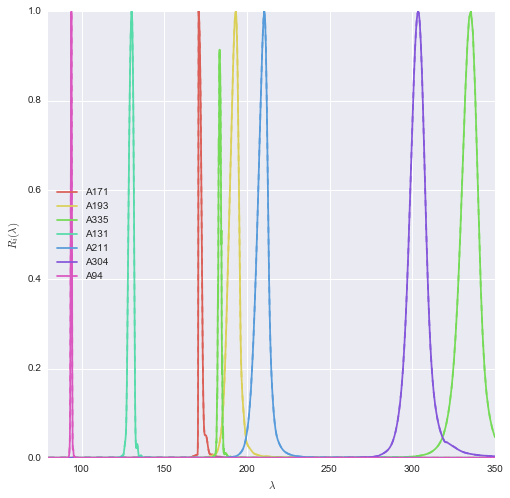

In [155]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
cp = sns.color_palette('hls',len(response))
for key,i in zip(response,range(len(response))):
    ax.plot(response[key]['wave'],response[key]['calc']/np.max(response[key]['calc']),color=cp[i],label=key)
    ax.plot(response[key]['wave'],response[key]['file']/np.max(response[key]['file']),color=cp[i],linestyle='dashed')
ax.set_xlim([80,350])
ax.legend(loc='best')
ax.set_ylabel(r'$R_i(\lambda)$')
ax.set_xlabel(r'$\lambda$')

Calculating the temperature response functions is now just a matter of pulling the relevant contribution functions from CHIANTI via ChiantiPy.